# Compare $A_{max}$  with $\eta$

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from mycurrents import oceanmooring as om

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV

from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart



import seaborn as sns
import pymc3 as pm
from theano import shared
from theano import tensor as tt

import matplotlib as mpl

import yaml

In [2]:
%matplotlib notebook

In [3]:
#ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_wout_motion.nc'
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

mode = 0

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan

A_n

<xarray.DataArray 'A_n' (time: 534962)>
array([-1.370098, -2.838263, -3.88022 , ..., 21.38045 , 22.28628 , 22.417656])
Coordinates:
    modes    int64 0
  * time     (time) datetime64[ns] 2016-04-30 ... 2017-05-07T18:00:00
Attributes:
    units:      m
    long_name:  Modal buoyancy amplitude

# Extract the tides at a point

In [4]:
# Load the tidal velocity
xpt, ypt = 123.346383, -13.75895

# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']
#tidecons = ['M2','S2','N2','K2',]
#tidecons = ['M2','S2',]

# This extract_phsamp function appears to be wrong so manually calculate the phase and amp

#ua,up,va,vp,ha,hp,omega = readotps.extract_phsamp(tidemod,np.array([xpt]),
#                        np.array([ypt]),basetime, tidecons)
#ha,hp

In [5]:
# Extract the tidal height for the whole period
basetime=datetime(2016,1,1)
time = TimeVector('20160401.000000','20170601.000000',3600)
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

#


Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


In [6]:
eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

#plt.figure()
#eta_ts.plot()
#plt.plot(time,eta_harmonic)

omega

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


[0.00014051890250864362,
 0.0001454441043328608,
 0.00013787969948654463,
 0.00014584231720055478,
 7.292115835787053e-05,
 6.759774415077306e-05,
 7.252294597499026e-05,
 6.495854112867408e-05]

In [7]:
# Hilbert transform to get the signal envelope
def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    result =0*t
    for ii in range(0,n):
        result += beta_s[2*ii]*np.cos(ff[ii] * t) + beta_s[2*ii+1]*np.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    result_i =  0*t
    for ii in range(0,n):
        result_i += beta_s[2*ii]*np.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*np.sin(ff[ii]*t + np.pi/2)

    return np.abs(result +1j*result_i)


In [8]:
#h_re, h_im = pol2cart(hp,ha)
h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()
beta_s,h_re


(array([-1.06601772, -0.73122609, -0.37532814,  0.61864121,  0.21996483,
        -0.04004684,  0.03488314, -0.15285152, -0.2309025 ,  0.05471623,
         0.10343546, -0.0833272 , -0.07918602, -0.00312958, -0.01255757,
         0.0274185 ]),
 array([[-1.06601772, -0.37532814,  0.21996483,  0.03488314, -0.2309025 ,
          0.10343546, -0.07918602, -0.01255757]]))

<IPython.core.display.Javascript object>


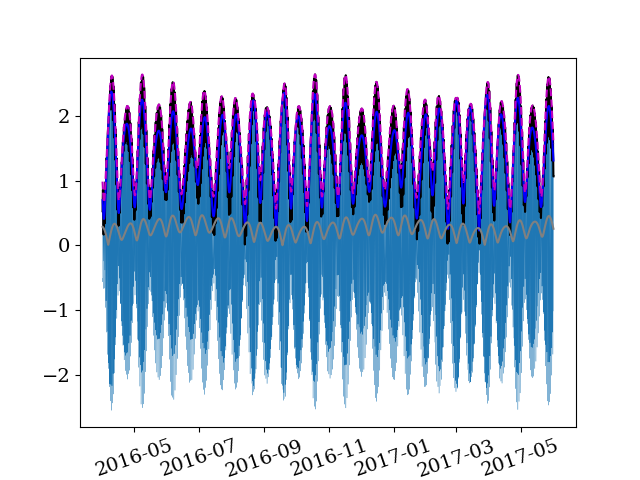

(array([736085., 736146., 736208., 736269., 736330., 736389., 736450.]),
 <a list of 7 Text xticklabel objects>)

In [9]:
t_tides = SecondsSince(eta_ts.t, basetime=basetime)
h_env_full = sine_model_envelope(beta_s, omega, t_tides)
h_D2_full = sine_model_envelope(beta_s[0:8], omega[0:4], t_tides)
h_D1_full = sine_model_envelope(beta_s[8:], omega[4:], t_tides)
h_D1D2_full = h_D2_full+h_D1_full
plt.figure()
plt.plot(eta_ts.t, eta_ts.y.ravel(), lw=0.2)
plt.plot(eta_ts.t, h_env_full,'k')
plt.plot(eta_ts.t, h_D2_full,'b')
plt.plot(eta_ts.t, h_D1_full,'0.5')
plt.plot(eta_ts.t, h_D1D2_full,'m--')


plt.xticks(rotation=19)

<IPython.core.display.Javascript object>


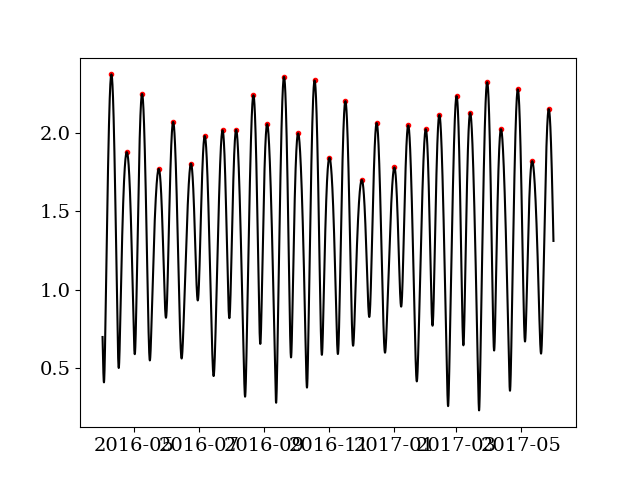

In [92]:
# Find the spring tide amplitudes and times
# ssh = h_D1D2_full
ssh = h_D2_full


# idx = signal.find_peaks_cwt(ssh, range(1,3))
idx,_ = signal.find_peaks(ssh)
time_spring = eta_ts.t[idx]
ssh_spring = ssh[idx]

plt.figure()
plt.plot(time_spring, ssh_spring,'r.')
plt.plot(eta_ts.t, ssh,'k')


In [67]:
def min_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    
def maximum_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    amp_max = np.nanmax(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

<IPython.core.display.Javascript object>


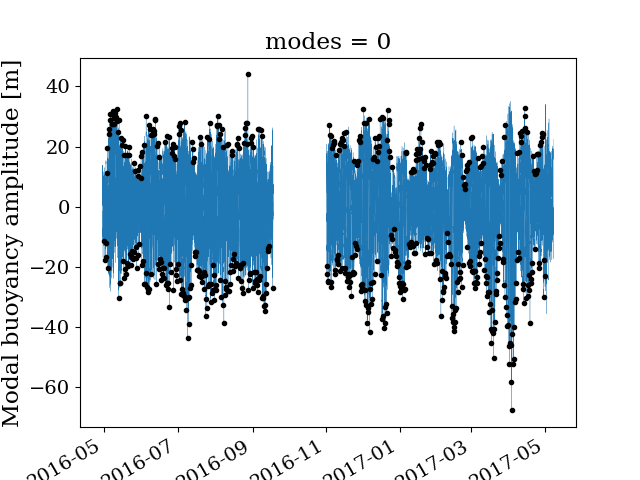

In [93]:
# Find the A_max over one day blocks
# Create a time series of single days with the max amplitude 
time1 = pd.date_range('2016-5-1','2016-9-15',freq='12.5H') 
time2 = pd.date_range('2016-11-1','2017-5-1',freq='12.5H')
timemax = time1.append(time2)


Amax_all = []
Amax_time = []
for t1,t2 in zip(timemax[0:-1],timemax[1::]):
    #t2 = t1 + np.timedelta64(1,'D')
    
    Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    #Amax, tidx = min_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)

    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')

In [94]:
# plt.figure()
# plt.plot(ds_A['time'], ds_A.values,'k.')
# plt.plot(time_spring, ssh_spring,'r.')

# Find the spring tide time for each amplitude observation
spring_amp = []
tlag = []
for tt in ds_A['time'].values:
    idx = np.argwhere(tt>time_spring)[-1,0]
    tlag.append( (tt - time_spring[idx]).view(int)*1e-9/86400)
    spring_amp.append(ssh_spring[idx])
    
# Convert to a dataframe
data = pd.DataFrame({'amp':ds_A.values, 'ssh':np.array(spring_amp), 'tlag':np.array(tlag)}, index=ds_A.time.values)

<IPython.core.display.Javascript object>


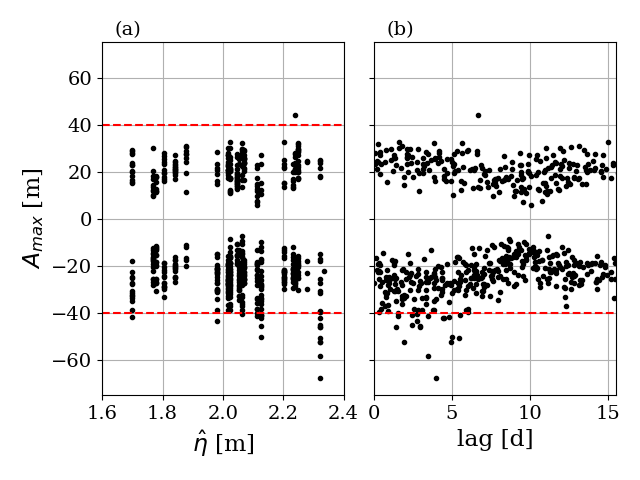

In [108]:
# waves = data.pivot("tlag", "ssh", "amp")

# ax= sns.jointplot(x="ssh", y="amp", data=data, marginal_kws=dict(bins=25, rug=False));
# #plt.plot([2,2.7],[-40,-40])
# ax

plt.figure()
ax=plt.subplot(121)
plt.plot(data['ssh'],data['amp'],'k.')
plt.plot([1.6,2.4],[-40,-40],'r--')
plt.plot([1.6,2.4],[40,40],'r--')

plt.ylim(-75,75)
plt.xlim(1.6,2.4)
plt.xlabel('$\hat{\eta}$ [m]')
plt.ylabel('$A_{max}$ [m]')
plt.grid(b=True)
plt.text(0.05,1.02,'(a)', transform=ax.transAxes)


ax2= plt.subplot(122)
plt.plot(data['tlag'],data['amp'],'k.')
plt.plot([0,15.5],[-40,-40],'r--')
plt.ylim(-75,75)
plt.xlim(0,15.5)
plt.xlabel('lag [d]')
ax2.set_yticklabels([])
plt.grid(b=True)
plt.text(0.05,1.02,'(b)', transform=ax2.transAxes)
plt.tight_layout()

plt.savefig('../FIGURES/Amax_vs_ssh.png',dpi=150)
plt.savefig('../FIGURES/Amax_vs_ssh.pdf',dpi=150)

<IPython.core.display.Javascript object>


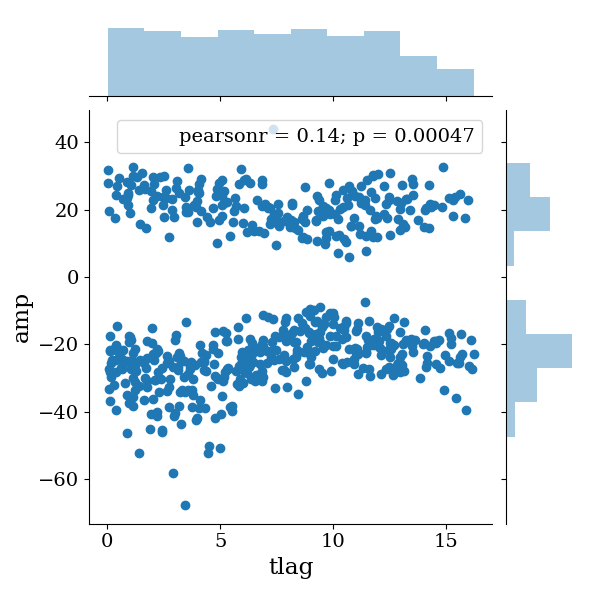

In [71]:
sns.jointplot(x="tlag", y="amp", data=data,);